In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from scipy.optimize import minimize

In [ ]:
m_min, m_max = 110, 150
sigma = 1.5
mH_true = 125
N_bkg_obs = 5000
N_sig_obs = 200

In [ ]:
np.random.seed(42)
bkg = []
while len(bkg) < N_bkg_obs:
    samples = np.random.exponential(scale=30, size=N_bkg_obs) + 100
    bkg.extend(samples[(samples >= m_min) & (samples <= m_max)])
background = np.array(bkg[:N_bkg_obs])
signal = np.random.normal(mH_true, sigma, N_sig_obs)
signal = sig[(sig >= m_min) & (sig <= m_max)]
data = np.concatenate([signal, background])

In [ ]:
def signal_pdf(m, mH):
    pdf = norm.pdf(m, loc=mH, scale=sigma)
    norm_const = norm.cdf(m_max, mH, sigma) - norm.cdf(m_min, mH, sigma)
    return pdf / norm_const

def background_pdf(m, slope):
    pdf = np.exp(-m / slope)
    norm_const = slope * (np.exp(-m_min/slope) - np.exp(-m_max/slope))
    return pdf / norm_const


def nll(params, mH_fixed, data):
    mu, B, slope = params
    if mu < 0 or B < 0 or slope <= 0: return 1e12

    fS = signal_pdf(data, mH_fixed)
    fB = background_pdf(data, slope)


    return (mu + B) - np.sum(np.log(mu * fS + B * fB + 1e-12))

In [ ]:
mass_grid = np.arange(m_min, m_max + 0.5, 0.5)
z_local = []
best_params_per_mass = []

print('Running mass scan...')
for m_hypo in mass_grid:

    res_null = minimize(nll, [0, 5000, 30], args=(m_hypo, data),
                        bounds=[(0,0), (1, 10000), (1, 100)])


    res_sig = minimize(nll, [200, 5000, 30], args=(m_hypo, data),
                       bounds=[(0, 1000), (1, 10000), (1, 100)])


    q0 = max(0, 2 * (res_null.fun - res_sig.fun))
    z_local.append(np.sqrt(q0))
    best_params_per_mass.append(res_sig.x)
print('Scan Done')

Running mass scan...
Scan Done


In [ ]:
z_local = np.array(z_local)
idx_max = np.argmax(z_local)
m_best = mass_grid[idx_max]
Z_max_local = z_local[idx_max]
best_mu, best_B, best_slope = best_params_per_mass[idx_max]

In [ ]:
N_eff = (m_max - m_min) / sigma
p_local = 1 - norm.cdf(Z_max_local)
p_global = N_eff * p_local
Z_global = norm.ppf(1 - p_global)

In [ ]:
print(f'\n--- SCAN RESULTS ---')
print(f'Discovery Mass:      {m_best:.1f} GeV')
print(f'Max Local Z:         {Z_max_local:.2f} sigma')
print(f'Global Z (LEE corr): {Z_global:.2f} sigma')


--- SCAN RESULTS ---
Discovery Mass:      125.0 GeV
Max Local Z:         6.68 sigma
Global Z (LEE corr): 6.19 sigma


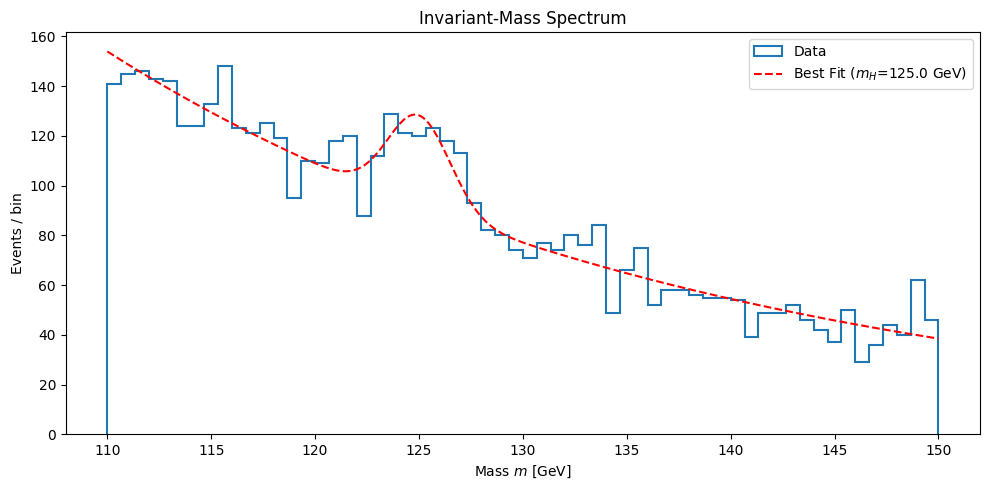

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

counts, bins, _ = ax1.hist(
    data, bins=60, range=(m_min, m_max),
    histtype='step', label='Data', linewidth=1.5
)

x_plot = np.linspace(m_min, m_max, 500)
bin_width = (m_max - m_min) / 60

y_fit = (
    best_mu * signal_pdf(x_plot, m_best)
    + best_B * background_pdf(x_plot, best_slope)
) * bin_width

ax1.plot(x_plot, y_fit, 'r--', label=f'Best Fit ($m_H$={m_best} GeV)')
ax1.set_title('Invariant-Mass Spectrum')
ax1.set_xlabel('Mass $m$ [GeV]')
ax1.set_ylabel('Events / bin')
ax1.legend()

fig1.tight_layout()
plt.show()



<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2516440088.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax2.axhline(3, color='orange', alpha=0.5, label='3$\sigma$ Evidence')
/tmp/ipython-input-2516440088.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax2.axhline(5, color='red', alpha=0.5, label='5$\sigma$ Discovery')


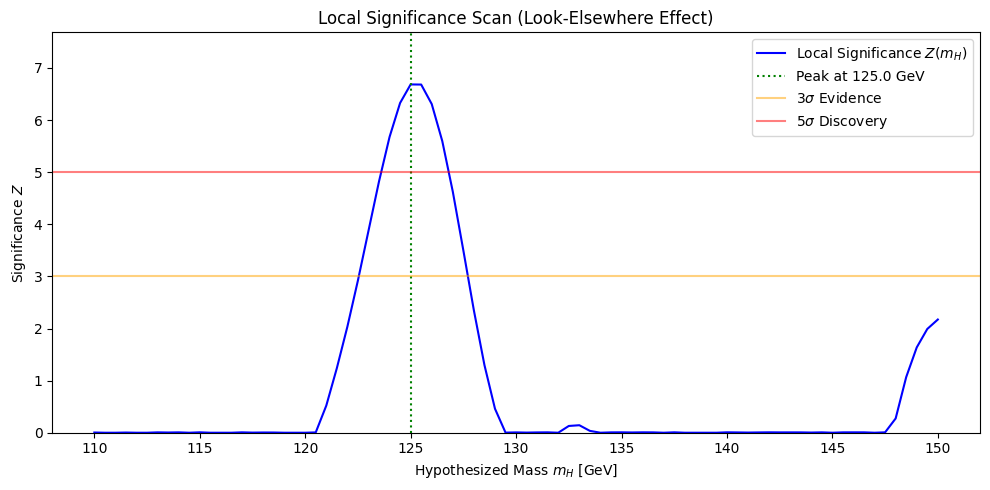

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(mass_grid, z_local, 'b-', label='Local Significance $Z(m_H)$')
ax2.axvline(m_best, color='green', linestyle=':', label=f'Peak at {m_best} GeV')
ax2.axhline(3, color='orange', alpha=0.5, label='3$\sigma$ Evidence')
ax2.axhline(5, color='red', alpha=0.5, label='5$\sigma$ Discovery')

ax2.set_title('Local Significance Scan (Look-Elsewhere Effect)')
ax2.set_xlabel('Hypothesized Mass $m_H$ [GeV]')
ax2.set_ylabel('Significance $Z$')
ax2.set_ylim(0, Z_max_local + 1)
ax2.legend()

fig2.tight_layout()
plt.show()
